In [2]:
import pandas as pd
import glob
import random
import os
import cv2
from sklearn.utils import shuffle
from numpy.random import seed
import numpy as np
from tensorflow.random import set_seed
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 100
seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(42)
warnings.filterwarnings('ignore')

In [3]:
img_size = 256
batch_size = 64
seed = 42

In [4]:
main_path = "../chest_xray/"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
validation_path = os.path.join(main_path,"val")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(validation_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(validation_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


#create list of paths
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

In [5]:
dic_data = {"train":[train_normal, train_pneumonia], "test":[test_normal, test_pneumonia] , "val":[val_normal, val_pneumonia]}
for key, value in dic_data.items():
    classes = [0]*len(value[0])    # Normal : 0 and Pneunomia : 1
    classes.extend([1]*len(value[1]))
    images_path = [x for x in value[0]]
    images_path.extend([x for x in value[1]])
    data = []
    i = 0
    for img_path in images_path:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            continue
        # resize image shape
        img = cv2.resize(img, (img_size, img_size))
        #normalize image
        img = img/255.0

        data.append([img, classes[i]])
        i = i+1
    df = pd.DataFrame(data, columns=['image', 'label'])
    df.to_pickle(f"{key}.pkl")

In [6]:
#read saved formated images
df_train  = pd.read_pickle(os.path.join(main_path,"train.pkl"))
df_test = pd.read_pickle(os.path.join(main_path,"test.pkl"))
df_val = pd.read_pickle(os.path.join(main_path,"val.pkl"))

### Reshape the loaded images

In [7]:
X_train, y_train = np.array([ img.reshape(img_size,img_size, 1) for img in df_train['image']]), np.array(df_train['label'])
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = np.array([ img.reshape(img_size,img_size, 1) for img in df_val['image']]), np.array(df_val['label'])
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = np.array([ img.reshape(img_size,img_size, 1) for img in df_test['image']]), np.array(df_test['label'])
X_test, y_test = shuffle(X_test, y_test, random_state=42)

#### Histogram

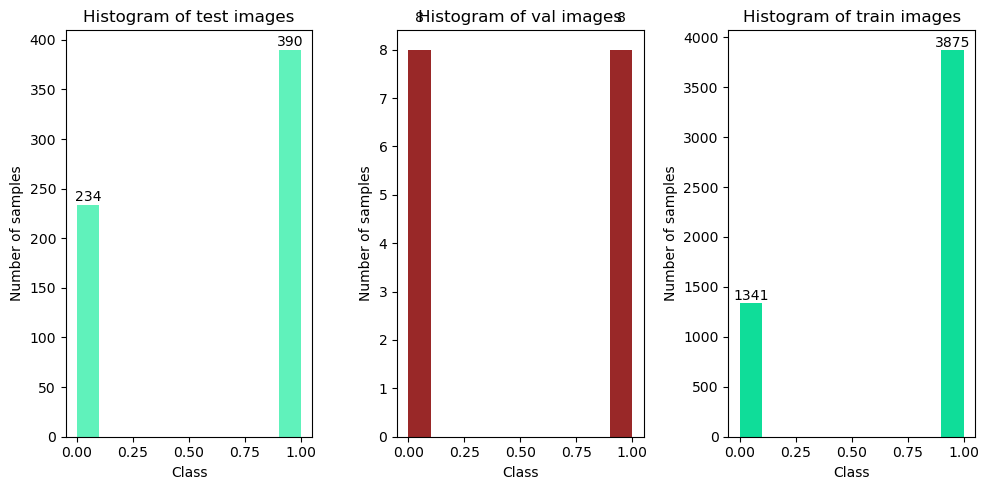

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
labels = ['test', 'val', 'train']
list_df = [df_test, df_val, df_train]
for i in range(len(axes)):
    n, bins, patches = axes[i].hist(list_df[i]['label'],color=np.random.rand(3))
    axes[i].set_title(f'Histogram of {labels[i]} images')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Number of samples')
    for j in range(len(n)):
        if n[j] > 0:
            axes[i].text(bins[j] + (bins[j+1] - bins[j])/2, n[j]+0.5, str(int(n[j])), ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Build CNN model from keras

In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Recall

# Build the model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.MaxPooling2D(pool_size=(2, 2)),  # Nouvelle couche pour réduire davantage
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])



# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[Recall()])

# Print the model summary to verify architecture
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,936,642 (7.39 MB)

 Trainable params: 1,936,642 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def get_model():

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size, img_size, 1))

    # Block One
    x = layers.Conv2D(filters=32, activation='relu', kernel_size=(3,3))(inputs)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=64, activation='relu', kernel_size=(3,3))(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block Three
    x = layers.Conv2D(filters=64, activation='relu', kernel_size=(3,3))(x)
    x = layers.Conv2D(filters=64,activation='relu', kernel_size=(3,3))(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation('relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Head
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

# Compile the model
keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy' , optimizer ='Adam', metrics=['accuracy','precision', 'AUC', 'recall']) #['precision', 'AUC', 'recall']

# Print the model summary to verify architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 58, 58, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,444,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,538,433 (13.50 MB)

 Trainable params: 3,537,985 (13.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
from sklearn.utils.class_weight import compute_class_weight

checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5',
                                             monitor='val_recall',
                                             save_best_only=True,
                                             mode='max',
                                             verbose=1)

# Compute the weight of the classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train),  y=y_train)

# create a dictionary containing all the weight
class_weights_dict = {0: 1 , 1: 10.}

# associate the weight to the model : by fitting
history = model.fit(X_train, y_train,
          batch_size=batch_size, epochs=10,
          validation_data=(X_val, y_val),
          class_weight=class_weights_dict)
          #callbacks=[checkpoint])   #callback is used to only choose the best model during the training


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - AUC: 0.9638 - loss: 0.4918 - precision: 0.7510 - recall: 0.9995 - val_AUC: 0.5000 - val_loss: 78.9150 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 443s 5s/step - AUC: 0.9776 - loss: 0.4617 - precision: 0.7547 - recall: 0.9987 - val_AUC: 0.5000 - val_loss: 87.7459 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 468s 6s/step - AUC: 0.9783 - loss: 0.3879 - precision: 0.9297 - recall: 0.9929 - val_AUC: 0.5000 - val_loss: 77.8575 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step - AUC: 0.9845 - loss: 0.3438 - precision: 0.9449 - recall: 0.9914 - val_AUC: 0.5000 - val_loss: 72.0969 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 366s 4s/step - AUC: 0.9890 - loss: 0.3042 - precision: 0.9515 - recall: 0.9955 - val_AUC: 0.5000 - val_loss: 69.4685 - val_precision: 0.5000 - val_recall: 1.0000


In [58]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

#summary classification
print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step
Confusion Matrix:
 [[234   0]
 [390   0]]
              precision    recall  f1-score   support

      Normal       0.38      1.00      0.55       234
   Pneumonia       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



**Task 1: Visualize training results**

To visualize the training results, we'll create a few plots to help us understand the model's performance. We'll use the `matplotlib` library to create these plots.

1. **Import the necessary libraries**:

In [73]:
import matplotlib.pyplot as plt
import numpy as np

X_test_flattened = X_test.reshape(X_test.shape[0], -1)

2. **Create a plot for the training and validation loss**:

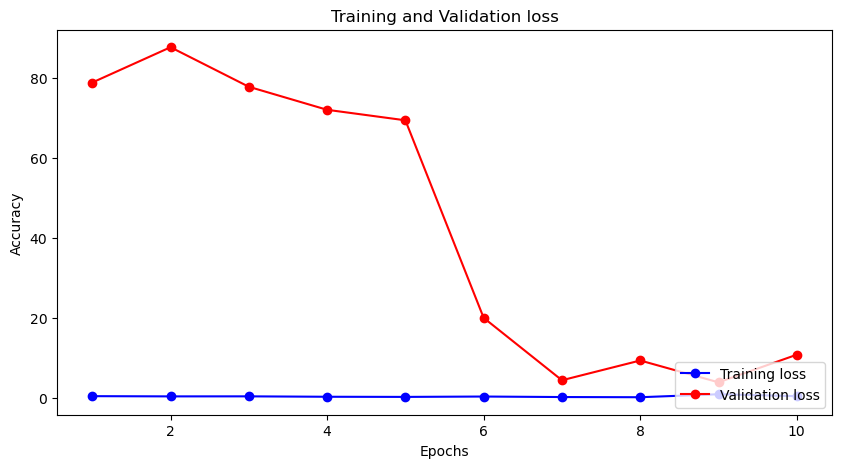

In [60]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 5))
'''''
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_loss, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
'''
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation loss')
plt.legend(loc='lower right')

plt.show()


This code creates a plot with the training loss and validation loss on the y-axis and the epochs on the x-axis.

3. **Create a plot for the training and validation accuracy**:

In [68]:
print(history.history.keys())

dict_keys(['AUC', 'loss', 'precision', 'recall', 'val_AUC', 'val_loss', 'val_precision', 'val_recall'])


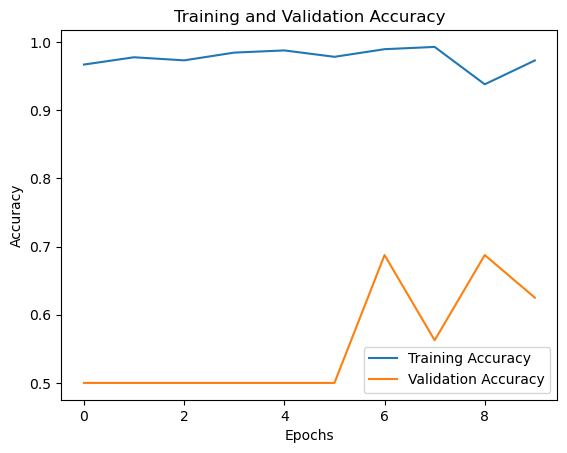

In [71]:
plt.plot(history.history['AUC'], label='Training Accuracy')
plt.plot(history.history['val_AUC'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

This code creates a plot with the training accuracy and validation accuracy on the y-axis and the epochs on the x-axis.

4. **Create a plot for the confusion matrix**:

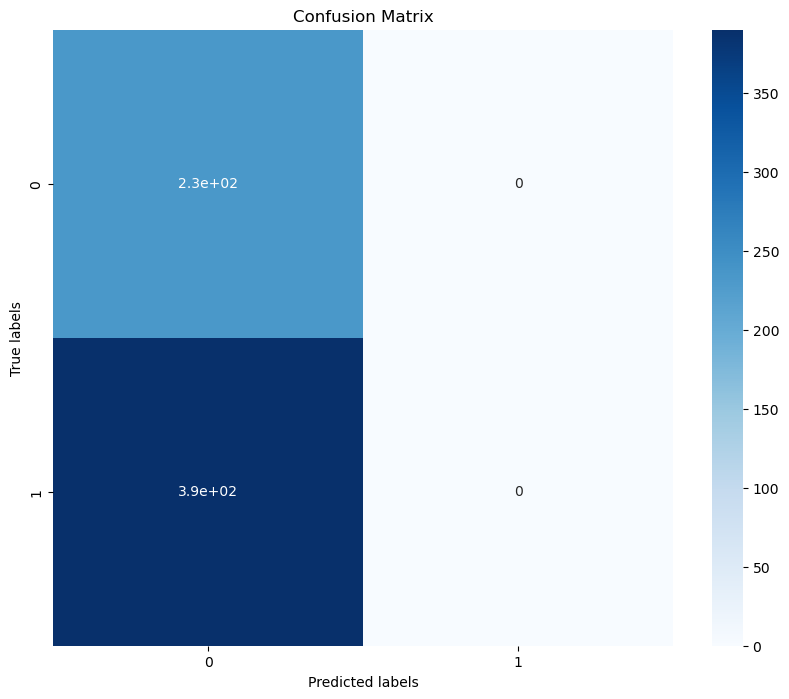

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

This code creates a heatmap of the confusion matrix, which shows the number of true positives, false positives, true negatives, and false negatives.


**Task 2: Analyze model performance**

To analyze the model's performance, we'll use a few techniques:

1. **Feature importance**:

In [76]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
print(perm_importance.importances_mean)

ValueError: Found array with dim 4. None expected <= 2.

This code calculates the feature importance using permutation importance.


2. **Partial dependence plots**:

In [36]:
from sklearn.inspection import partial_dependence

pd = partial_dependence(model, X_test, y_test, n_jobs=-1)
print(pd)

TypeError: got an unexpected keyword argument 'n_jobs'

This code creates a partial dependence plot, which shows the relationship between the feature and the predicted output.

3. **SHAP values**:

In [42]:
import shap

shap_values = shap.TreeExplainer(model).shap_values(X_test)
print(shap_values)

ModuleNotFoundError: No module named 'shap'

This code calculates the SHAP values, which show the contribution of each feature to the predicted output.

**Task 3: Save evaluation results**

To save the evaluation results, we'll use a few methods:


1. **Save the confusion matrix to a CSV file**:

In [38]:
import pandas as pd

cm = confusion_matrix(y_test, y_pred_classes)
pd.DataFrame(cm).to_csv('confusion_matrix.csv', index=False)

This code saves the confusion matrix to a CSV file.

2. **Save the feature importance to a CSV file**:

In [39]:
import pandas as pd

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
pd.DataFrame(perm_importance.importances_mean).to_csv('feature_importance.csv', index=False)

ValueError: Found array with dim 4. None expected <= 2.

This code saves the feature importance to a CSV file.

3. **Save the SHAP values to a CSV file**:

In [40]:
import pandas as pd

shap_values = shap.TreeExplainer(model).shap_values(X_test)
pd.DataFrame(shap_values).to_csv('shap_values.csv', index=False)

NameError: name 'shap' is not defined

This code saves the SHAP values to a CSV file.